# "PyMC3 with labeled coords and dims"
> "Go crazy with your virtual label-maker!"

- toc: true 
- author: Oriol Abril
- badges: true
- categories: [python, arviz, pymc3, xarray]
- tags: [data storage]
- image: images/nb/labeled_arys.png
- twitter_large_image: true

In [ ]:
import numpy as np
import pymc3 as pm

## For the :heart: of labeled arrays

## Extra: generating the post image

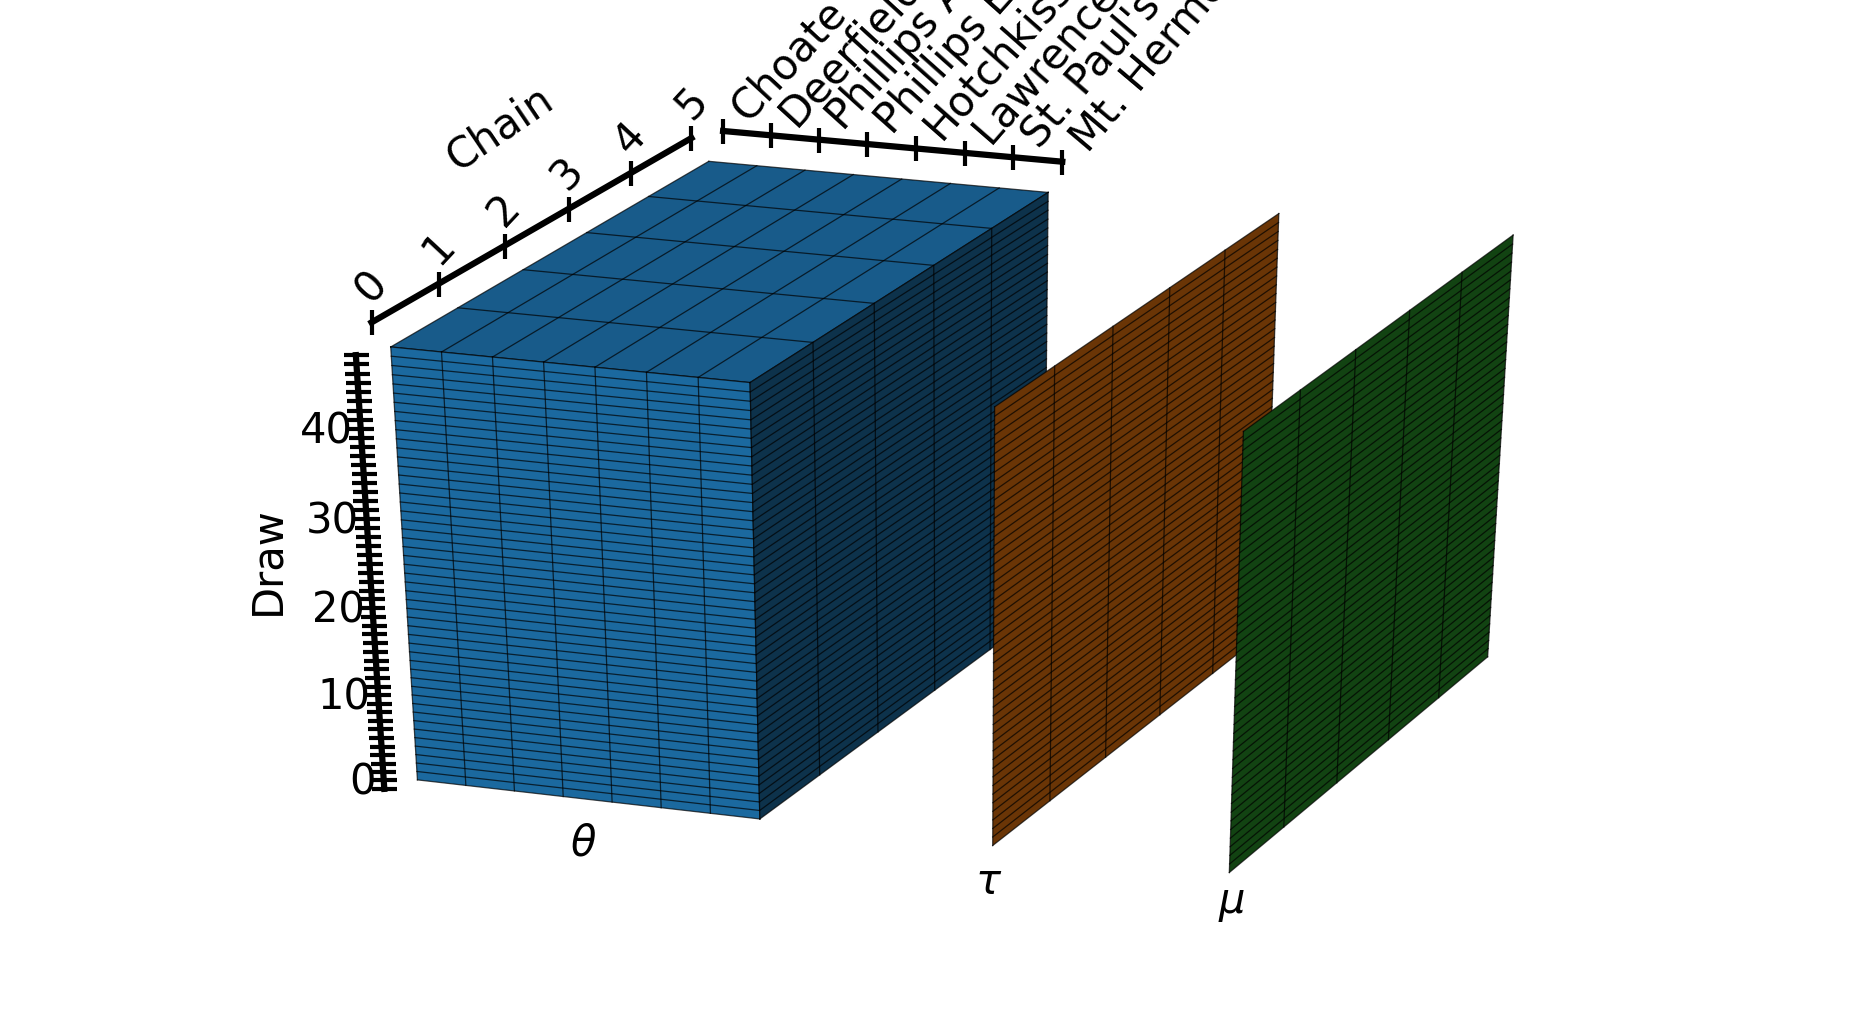

In [1]:
#collapse-hide
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

points = np.array([
    [-1, -1, -1],
    [1, -1, -1 ],
    [1, 1, -1],
    [-1, 1, -1],
    [-1, -1, 1],
    [1, -1, 1 ],
    [1, 1, 1],
    [-1, 1, 1]
])

fig = plt.figure(dpi=300)
ax = fig.add_axes([0, .05, 1, .8], projection='3d')
side = 3 
r = side * np.array([-1,1])
one_2d = side * np.ones((1,1))
one_1d = side * np.ones(1)
X, Y = np.meshgrid(r, r)

################
###  theta   ###
################
ax.plot_surface(X,Y,one_2d, color="C0", zorder=1)
ax.plot_surface(X,-one_2d,Y, color="C0", zorder=1)
ax.plot_surface(one_2d,X,Y, color="C0", zorder=1)
ax.text2D(0.3, 0.14, r"$\theta$", transform=ax.transAxes)

# school dim
school_grid = np.linspace(-1, 1, 8) * side
school_one = np.ones_like(school_grid) * side * 1.1
schools = np.array(["Choate", "Deerfield", "Phillips Andover", "Phillips Exeter", 
                    "Hotchkiss", "Lawrenceville", "St. Paul's", "Mt. Hermon"])
ax.plot(school_grid, school_one, school_one, marker="|", color="k")
for school, pos in zip(schools, school_grid):
    ax.text(pos, side*1.1, side*1.15, f"{school}", zdir="y", clip_on=False)
    
# chain dim
chain_grid = np.linspace(-1, 1, 6) * side
chain_one = np.ones_like(chain_grid) * side * 1.1
ax.plot(-chain_one, chain_grid, chain_one, marker="|", color="k")
for chain, pos in enumerate(chain_grid):
    ax.text(-side*1.1, pos, side*1.15, f"{chain}", zdir="y", va="bottom", ha="center")
ax.text(-side*1.3, 0, side*1.3, "Chain", zdir=(1, 1, .2), va="bottom", ha="center")
    
# draw dim
draw_grid = np.linspace(-1, 1, 50) * side
draw_one = np.ones_like(draw_grid) * side * 1.1
draws = np.arange(0, 50, 10)
ax.plot(-draw_one, -draw_one, draw_grid, marker="_", color="k")
for draw, pos in zip(draws, draw_grid[draws]):
    ax.text(-side*1.1, -side*1.15, pos, f"{draw}", zdir=None, ha="right")
ax.text2D(0.12, 0.4, "Draw", transform=ax.transAxes, rotation="vertical")

################
###   tau    ###
################
ax.plot_surface(4+one_2d,X,Y, color="C1", zorder=1)
ax.text2D(0.525, 0.1, r"$\tau$", transform=ax.transAxes)


################
###    mu    ###
################
ax.plot_surface(8+one_2d,X,Y, color="C2", zorder=1)
ax.text2D(0.66, 0.08, r"$\mu$", transform=ax.transAxes)


################
###  grids   ###
################
grid = np.linspace(-1, 1, 10) * side
grid_one = np.ones(10)
lw = .3; alpha = .7
for chain_pos in chain_grid:
    ax.plot(grid, grid_one * chain_pos, grid_one * side, color="k", alpha=alpha, zorder=3, lw=lw)
    ax.plot(grid_one * side, grid_one * chain_pos, grid, color="k", alpha=alpha, zorder=5, lw=lw)
    ax.plot(grid_one * side + 4, grid_one * chain_pos, grid, color="k", alpha=alpha, zorder=6, lw=lw)
    ax.plot(grid_one * side + 8, grid_one * chain_pos, grid, color="k", alpha=alpha, zorder=7, lw=lw)
for draw_pos in draw_grid:
    ax.plot(grid, -grid_one * side, grid_one * draw_pos,  color="k", alpha=alpha, zorder=4, lw=lw)
    ax.plot(grid_one * side, grid, grid_one * draw_pos,  color="k", alpha=alpha, zorder=5, lw=lw)
    ax.plot(grid_one * side + 4, grid, grid_one * draw_pos,  color="k", alpha=alpha, zorder=6, lw=lw)
    ax.plot(grid_one * side + 8, grid, grid_one * draw_pos,  color="k", alpha=alpha, zorder=7, lw=lw)
for school_pos in school_grid:
    ax.plot(grid_one * school_pos, grid, grid_one * side,  color="k", alpha=alpha, zorder=4, lw=lw)
    ax.plot(grid_one * school_pos, -grid_one * side, grid, color="k", alpha=alpha, zorder=4, lw=lw)

ax.axis("off");
ax.view_init(azim=-69)
#fig.savefig("labeled_arys.png", dpi=300)